In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# Statsmodels for regression (gives p-values)
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Sklearn for Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Plot style
sns.set(style="whitegrid")

# Load the merged dataset
BASE = Path("..") / "data" / "processed"
df = pd.read_csv(BASE / "combined_state_summary_2022.csv")

df.head()


,StateFIPS,State,Abbrev,obesity_rate,smoking_rate,incidence_rate_adj,incidence_cases
0,1,Alabama,AL,35.703,14.895,40.9,2568.0
1,2,Alaska,AK,28.789,14.699,40.8,306.0
2,4,Arizona,AZ,29.385,11.471,31.9,2945.0
3,5,Arkansas,AR,32.196,16.560,41.5,1541.0
4,6,California,CA,23.565,8.590,34.4,15465.0


In [4]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   StateFIPS           51 non-null     int64  
 1   State               51 non-null     object 
 2   Abbrev              51 non-null     object 
 3   obesity_rate        51 non-null     float64
 4   smoking_rate        51 non-null     float64
 5   incidence_rate_adj  51 non-null     float64
 6   incidence_cases     51 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.9+ KB


,StateFIPS,obesity_rate,smoking_rate,incidence_rate_adj,incidence_cases
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,28.960784,29.919588,12.578686,36.919608,2900.607843
std,15.832828,3.996575,2.761359,3.873088,3168.793216
min,1.000000,21.269000,6.167000,29.800000,229.000000
25%,16.500000,27.225000,10.193500,34.050000,797.500000
50%,29.000000,30.275000,13.001000,36.600000,2031.000000
75%,41.500000,32.408000,14.461500,39.450000,3182.000000
max,56.000000,38.131000,19.950000,46.100000,15465.000000


In [5]:
model = smf.ols(
    formula="incidence_rate_adj ~ obesity_rate + smoking_rate",
    data=df
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     incidence_rate_adj   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     20.26
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           4.17e-07
Time:                        13:38:52   Log-Likelihood:                -125.31
No. Observations:                  51   AIC:                             256.6
Df Residuals:                      48   BIC:                             262.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.6484      3.236      6.072   

In [6]:
model_params = model.params
model_pvals = model.pvalues
model_r2 = model.rsquared
model_r2_adj = model.rsquared_adj

model_params, model_pvals, model_r2, model_r2_adj


(Intercept       19.648415
 obesity_rate     0.398038
 smoking_rate     0.426282
 dtype: float64,
 Intercept       1.943098e-07
 obesity_rate    2.134813e-02
 smoking_rate    8.462726e-02
 dtype: float64,
 np.float64(0.45777425017093454),
 np.float64(0.43518151059472343))

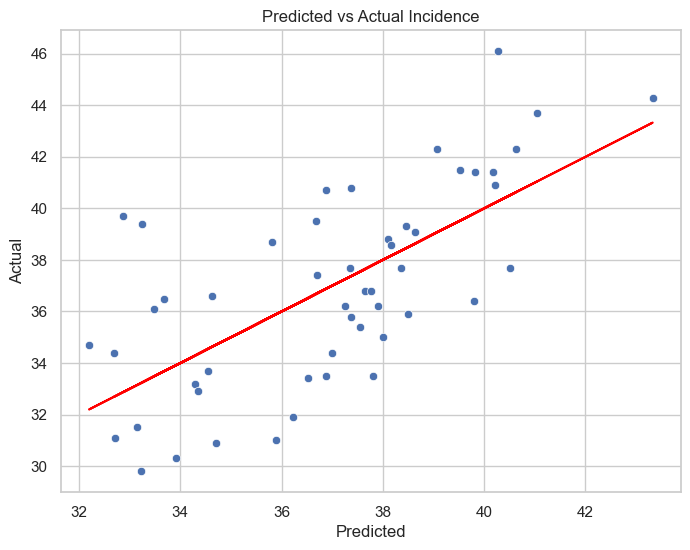

In [7]:
df["predicted"] = model.predict(df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df["predicted"], y=df["incidence_rate_adj"])
plt.plot(df["predicted"], df["predicted"], color="red")  # reference line
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual Incidence")
plt.show()


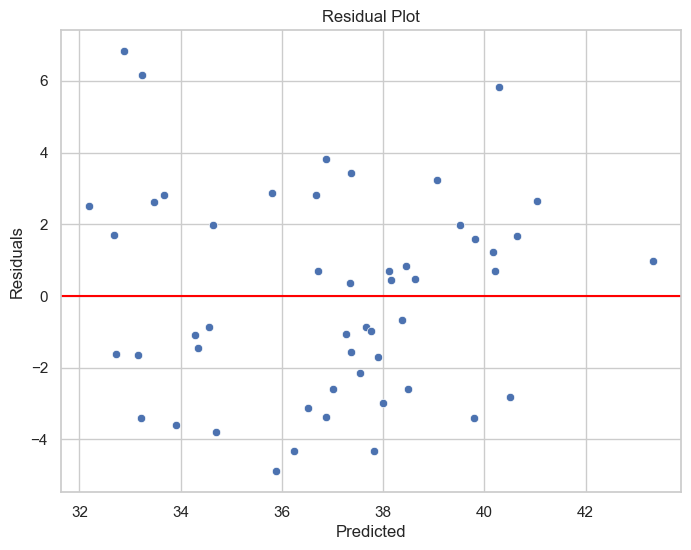

In [8]:
df["residuals"] = df["incidence_rate_adj"] - df["predicted"]

plt.figure(figsize=(8,6))
sns.scatterplot(x=df["predicted"], y=df["residuals"])
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


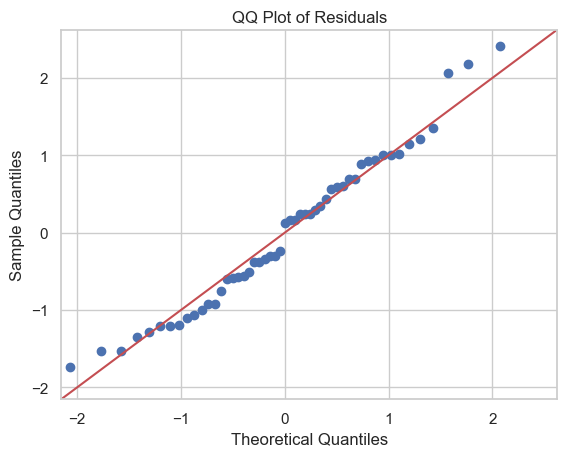

In [9]:
sm.qqplot(df["residuals"], line="45", fit=True)
plt.title("QQ Plot of Residuals")
plt.show()


In [10]:
X = df[["obesity_rate", "smoking_rate"]]
y = df["incidence_rate_adj"]

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X, y)
rf_pred = rf.predict(X)
rf_r2 = r2_score(y, rf_pred)

print("Random Forest R²:", rf_r2)


Random Forest R²: 0.89305179875803


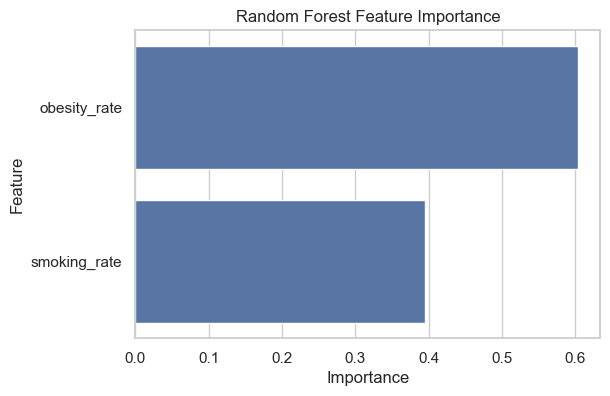

In [11]:
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=features)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [12]:
scores = cross_val_score(rf, X, y, cv=5)
print("Cross-validated R² scores:", scores)
print("Mean CV R²:", scores.mean())


Cross-validated R² scores: [0.0592521  0.09851241 0.49022546 0.10973491 0.19757366]
Mean CV R²: 0.19105970974682668
